In [ ]:
# I need to do 2 things
# 1. get the MIS-cell functional groups (TME and non-TME) with spatial proximity to define the local interaction regions
# 2. get the SAE associted GO and pathways for each cell to define the interpretable features

# 3. then I need to think about how to calcualte CCC based on 1 and 2 here.

In [1]:
import scanpy as sc

adata_interp = sc.read_h5ad('/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/ccc/data/adata_interpretable_sec8_final.h5ad')

In [2]:
adata_interp

AnnData object with n_obs × n_vars = 81236 × 393
    obs: 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'niche', 'image_id', 'cell_ID', 'sex_ontology_term_id', 'assay_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'tissue_type', 'condition_id', 'sample_id', 'donor_id', 'author_cell_type', 'library_key', 'region', 'assay', 'organism', 'sex', 'tissue', 'dataset', 'x', 'y', 'nicheformer_split', '_scvi_batch', '_scvi_labels', 'shards', 'compartment', 'compartment_conf', 'prob_Tumor', 'prob_TME', 'prob_Interface', 'score_Tumor', 'score_TME', 'score_Interface', 'spatial_x', 'spatial_y'
    uns: 'concept_feature_build'
    obsm: 'X_compartment_probs', 'X_compartment_scores', 'spatial'

# Ontology assembly & concept mapping

In [30]:
import re
import pandas as pd
from collections import OrderedDict

# =========================
# 1) Mechanistic channels
# =========================
CHANNEL_REGEX = OrderedDict([
    ("Immune communication", [
        r"\b(immune|immunolog|leukocyte|lymphocyte|myeloid|neutrophil|monocyte|macrophage|dendritic|b[- ]?cell|t[- ]?cell|nk cell|plasmablast|pdc)\b",
        r"\b(cytokine|chemokine|interleukin|il[- ]?\d+|cc[lr]?\d+|cx[cl]\d+|ifn[abg]|interferon|tnf|tumou?r necrosis factor)\b",
        r"\b(mhc|h[la]-[a-z0-9]+|antigen (?:processing|presentation)|cross[- ]?presentation|peptide antigen binding)\b",
        r"\b(checkpoint|pd[- ]?1|pd[- ]?l1|ctla[- ]?4|lag[- ]?3|tigit|tim[- ]?3)\b",
        r"\b(complement|c\d+\s*component|immunological synapse)\b",
        r"\b(degranulation|granule|pattern recognition receptor|tlr|prr)\b",
        r"\bnf[- ]?kappa?b|i[- ]?kappa?b\b",
        r"\bnatural killer\b",
    ]),
    ("Extracellular matrix and structural remodeling", [
        r"\b(extracellular matrix|ecm|matrisome|collagen|laminin|fibronectin)\b",
        r"\b(integrin|itga\d+|itgb\d+|focal adhesion|adhesion)\b",
        r"\b(matrix remodeling|mmp\d+|metalloproteinase|timp)\b",
        r"\b(cytoskeleton|actin|microtubule|intermediate filament|stress fiber|supramolecular fiber)\b",
        r"\b(tight junction|adherens junction|desmosome|junction (?:assembly|organization))\b",
        r"\bstromal|myofibroblast|caf\b",
    ]),
    ("Metabolic communication", [
        r"\b(glycolysis|gluconeogenesis|pentose phosphate|tca cycle|oxidative phosphorylation|oxphos)\b",
        r"\b(lipid|fatty acid|cholesterol|sterol|bile|ketone|peroxisome|beta[- ]?oxidation)\b",
        r"\b(amino acid|glutamine|serine|folate|one[- ]carbon)\b",
        r"\b(mt?or|ampk|metabolic)\b",
        r"\b(lactate|monocarboxylate transporter|mct)\b",
        r"\b(prostaglandin|prostanoid|eicosanoid)\b",
        r"\b(nitric oxide biosynthetic process)\b",
    ]),
    ("Angiogenesis and vascular signaling", [
        r"\b(angiogenesis|vascular|vasculature|blood vessel|endothelial|pericyte|sprouting)\b",
        r"\b(vegf|vegfr|flt1|kdr|tek|tie2)\b",
        r"\b(platelet (?:activation|aggregation)|coagulation|vascular permeability|circulation|blood pressure)\b",
        r"\bnitric[- ]?oxide(?! synthase\b)\b",
    ]),
    ("Hypoxia and stress response", [
        r"\b(hypoxia|hif[- ]?1[aα]?|hypoxic)\b",
        r"\b(oxidative stress|reactive oxygen|ros|nrf2)\b",
        r"\b(er stress|unfolded protein response|upr|atf4|perk|ire1|xbp1)\b",
        r"\b(heat shock|hsp\d+|stress response|senescence)\b",
        r"\b(response to (?:radiation|uv[- ]?b?|oxygen|starvation|metal ion|temperature))\b",
        r"\b(calcium[- ]mediated signaling|intracellular calcium ion homeostasis)\b",
    ]),
    ("Proliferation and DNA damage response", [
        r"\b(cell cycle|mitosis|g1|s phase|g2|m phase|proliferation|e2f targets|myc targets)\b",
        r"\b(dna repair|homologous recombination|non[- ]?homologous end[- ]?joining|mismatch repair|dna damage response)\b",
        r"\b(replication stress|checkpoint kinase|atr|atm|chk1|chk2|p53)\b",
        r"\b(mapk|erk|pi3k|akt|raf|mek|jnk)\b",
        r"\b(receptor tyrosine kinase|rtk|protein kinase activity|autophosphorylation|peptidyl[- ]?tyrosine phosphorylation)\b",
        r"\b(signal(?:ing)? (?:pathway|cascade)|receptor (?:activity|binding)|transducer activity)\b",
        r"\b(insulin[- ]like growth factor|igf|igfbp)\b",
    ]),
    ("Epithelial–mesenchymal transition and migration", [
        r"\b(emt|epithelial[- ]?mesenchymal)\b",
        r"\b(migration|motility|invasion|filopodia|lamellipodia|rhoa|rac1|cdc42)\b",
        r"\b(epithelial polarity|junction reorganization|cell[- ]?cell fusion|syncytium)\b",
        r"\b(wound healing|morphogenesis|epithelial (?:cell )?differentiation)\b",
        r"\b(tgf[- ]?β|transforming growth factor beta)\b",
    ]),
    ("Vesicle trafficking & secretion", [
        r"\b(golgi|early endosome|late endosome|lysosome|lytic vacuole|secretory granule)\b",
        r"\b(vesicle|endocytosis|exocytosis|plasma membrane invagination)\b",
        r"\b(protein transport|protein localization|establishment of localization)\b",
        r"\b(peptide secretion|regulation of secretion)\b",
    ]),
])

# ==================================
# 2) Generic THEMES (for leftovers)
#    (kept distinct, not used for CCC)
# ==================================
GENERIC_REGEX = OrderedDict([
    ("Generic: Development & Morphogenesis", [
        r"\b(system|multicellular organism|organ|tissue|embryo(?:nic)?|morphogenesis|development)\b",
        r"\b(neurogenesis|mesoderm|metanephros|renal tubule|pancreas|cardiac chamber|skin|muscle)\b",
        r"\b(implantation|epiboly)\b",
    ]),
    ("Generic: Localization & Transport", [
        r"\b(localization|transport|protein localization|establishment of localization)\b",
        r"\b(intracellular transport|organelle lumen|plasma membrane)\b",
        r"\b(vesicle membrane|plasma membrane invagination)\b",
    ]),
    ("Generic: Signaling (broad/unspecified)", [
        r"\b(signal(?:ing)? (?:pathway|cascade)|signaling receptor regulator activity|intracellular signaling cassette)\b",
        r"\b(positive|negative) regulation of .+\b",
        r"\b(regulation of (?:biological process|.* differentiation|.* activation|.* secretion|.* organization))\b",
        r"\b(transcription (?:co)?activator binding|transcription coregulator binding|rna polymerase ii)\b",
    ]),
    ("Generic: Metabolism & Biosynthesis (broad)", [
        r"\b(biosynthetic process|metabolic process|macromolecule modification)\b",
        r"\b(phosphotransferase activity, alcohol group as acceptor)\b",
    ]),
    ("Generic: Homeostasis & Ion balance", [
        r"\b(homeostasis|ion homeostasis|monoatomic cation|inorganic ion)\b",
        r"\b(calcium[- ]mediated signaling)\b",
    ]),
    ("Generic: Cell death & Apoptosis (broad)", [
        r"\b(programmed cell death|apoptotic|necroptotic)\b",
    ]),
    ("Generic: Response to Stimulus (broad)", [
        r"^response to .+$",
        r"\b(detection of biotic stimulus|response to (?:alcohol|acid chemical|temperature|metal ion|uv|radiation|oxygen|starvation))\b",
    ]),
    ("Generic: Host–pathogen / Symbiont", [
        r"\b(symbiont entry into host( cell)?|modulation by symbiont|disruption of.* in another organism)\b",
    ]),
    ("Generic: Cell population/number", [
        r"\b(maintenance of cell number)\b",
    ]),
])

GENERIC_REGEX.update({
    "Generic: Binding & Catalytic Activity": [
        r"\b(binding|catalytic activity|enzyme activity|protease binding|phosphotransferase)\b",
        r"\b(kinase activator|non[- ]membrane spanning protein tyrosine kinase)\b",
    ],
    "Generic: Cellular Response (unspecified)": [
        r"cellular response to .+",
    ],
    "Generic: Neural/Glial": [
        r"\b(glial|microglial|neurogenesis|somatodendritic)\b",
    ],
})

GENERIC_CHANNELS = set(GENERIC_REGEX.keys())

# =========================
# 3) Backfills & Overrides
# =========================
BACKFILL = OrderedDict([
    (r"\bnf[- ]?kappa?b|i[- ]?kappa?b\b", "Immune communication"),
    (r"\b(peptide antigen binding|immune system process|leukocyte|lymphocyte|humoral immune response)\b", "Immune communication"),
    (r"\b(platelet (?:activation|aggregation)|coagulation|vascular process|blood circulation|blood pressure)\b", "Angiogenesis and vascular signaling"),
    (r"\b(cytoskeleton organization|stress fiber|supramolecular fiber organization|adherens junction|tight junction)\b", "Extracellular matrix and structural remodeling"),
    (r"\b(epithelial (?:cell )?differentiation|epithelial tube formation|junction (?:assembly|organization)|wound healing)\b", "Epithelial–mesenchymal transition and migration"),
    (r"\b(pi3k|akt|mapk|erk|jnk|rtk|protein kinase activity|autophosphorylation|peptidyl[- ]?tyrosine phosphorylation)\b", "Proliferation and DNA damage response"),
    (r"\b(biosynthetic process|steroid biosynthetic process|monooxygenase activity|prostanoid|prostaglandin)\b", "Metabolic communication"),
    (r"\b(nitric[- ]?oxide synthase regulator activity)\b", "Angiogenesis and vascular signaling"),
])

EXACT_OVERRIDES = {
    # Vesicle/secretory
    "Golgi apparatus": "Vesicle trafficking & secretion",
    "early endosome": "Vesicle trafficking & secretion",
    "lysosome localization": "Vesicle trafficking & secretion",
    "lytic vacuole": "Vesicle trafficking & secretion",
    "plasma membrane": "Vesicle trafficking & secretion",
    "plasma membrane invagination": "Vesicle trafficking & secretion",
    "protein transport": "Vesicle trafficking & secretion",
    "protein localization": "Vesicle trafficking & secretion",
    "establishment of localization": "Vesicle trafficking & secretion",
    "establishment of protein localization to extracellular region": "Vesicle trafficking & secretion",
    "peptide secretion": "Vesicle trafficking & secretion",
    # Growth factor
    "insulin-like growth factor binding": "Proliferation and DNA damage response",
    "insulin-like growth factor binding protein complex": "Proliferation and DNA damage response",
    # Vascular NO synthase regulator
    "nitric-oxide synthase regulator activity": "Angiogenesis and vascular signaling",
}

# =========================
# 4) Parser helpers
# =========================
REG_RE  = re.compile(r"^(?:positive|negative)\s*regulation of (.+)$", re.I)
RESP_RE = re.compile(r"^response to (.+)$", re.I)

def _strip_quotes(s: str) -> str:
    return s.strip().strip('"').strip("'")

def _match_first(regex_dict, text):
    for channel, pats in regex_dict.items():
        for p in pats:
            if re.search(p, text, flags=re.I):
                return channel
    return None

def classify_term(term, multi=True):
    raw = str(term or "")
    s   = raw.lower().strip()

    # 0) exact overrides
    if raw in EXACT_OVERRIDES:
        ch = EXACT_OVERRIDES[raw]
        return ch, [ch] if multi else [], ch in GENERIC_CHANNELS, (ch if ch in GENERIC_CHANNELS else None)

    # 1) unwrap "regulation of X"
    m = REG_RE.match(s)
    if m:
        inner = _strip_quotes(m.group(1))
        ch, mlist, is_gen, theme = classify_term(inner, multi=multi)
        # If inner is still unclassified, fall back to Generic Signaling
        if ch == "Unclassified":
            return "Generic: Signaling (broad/unspecified)", (["Generic: Signaling (broad/unspecified)"] if multi else []), True, "Generic: Signaling (broad/unspecified)"
        return ch, mlist, is_gen, theme

    # 2) unwrap "response to Y"
    m = RESP_RE.match(s)
    if m:
        inner = _strip_quotes(m.group(1))
        # quick immune hook
        if re.search(r"\btumou?r\b|\bpathogen\b|\bbacteria|virus\b", inner, re.I):
            return "Immune communication", ["Immune communication"] if multi else [], False, None
        # stress hook
        if re.search(r"\b(uv|radiation|oxygen|starvation|metal ion|temperature|hypoxi)\b", inner, re.I):
            return "Hypoxia and stress response", ["Hypoxia and stress response"] if multi else [], False, None
        ch, mlist, is_gen, theme = classify_term(inner, multi=multi)
        if ch == "Unclassified":
            return "Generic: Response to Stimulus (broad)", (["Generic: Response to Stimulus (broad)"] if multi else []), True, "Generic: Response to Stimulus (broad)"
        return ch, mlist, is_gen, theme

    # 3) mechanistic channels
    ch = _match_first(CHANNEL_REGEX, s)
    if ch:
        # also collect any other mechanistic matches for channel_multi
        multis = []
        if multi:
            for alt, pats in CHANNEL_REGEX.items():
                if alt == ch: 
                    multis.append(alt); continue
                if any(re.search(p, s, re.I) for p in pats):
                    multis.append(alt)
            multis = sorted(set(multis))
        return ch, multis, False, None

    # 4) backfills to mechanistic
    for p, mech in BACKFILL.items():
        if re.search(p, s, flags=re.I):
            return mech, [mech] if multi else [], False, None

    # 5) generic themes
    gen = _match_first(GENERIC_REGEX, s)
    if gen:
        return gen, [gen] if multi else [], True, gen

    # 6) still nothing
    return "Unclassified", [], True, None

def classify_terms_to_df(terms, multi=True):
    rows = []
    for t in terms:
        ch, mlist, is_gen, theme = classify_term(t, multi=multi)
        rows.append({
            "concept": t,
            "channel_primary": ch,
            "channel_multi": ";".join(mlist) if mlist else "",
            "is_generic": bool(is_gen),
            "generic_theme": theme if is_gen else None,
        })
    return pd.DataFrame(rows)

# =========================
# 5) Usage
# =========================
concepts = adata_interp.var_names.astype(str)   # your interpretable-feature names
df = classify_terms_to_df(concepts)
# print(df["channel_primary"].value_counts().sort_values(ascending=False))

# —— Downstream tip: keep mechanistic channels only for crosstalk inference ——
df_mech = df[~df["is_generic"] & (df["channel_primary"] != "Unclassified")].copy()
df_generic = df[df["is_generic"]].copy()  # for reporting/QA but excluded from scoring

# 6) Write onto adata_interp.var (safe merge by index)
df = df.set_index("concept").reindex(adata_interp.var_names)

# Ensure expected columns exist
for c in ["channel_primary", "channel_multi", "is_generic", "generic_theme"]:
    if c not in df.columns:
        df[c] = pd.NA

adata_interp.var["channel_primary"]  = pd.Categorical(df["channel_primary"].fillna("Unclassified"))
adata_interp.var["channel_multi"]    = df["channel_multi"].fillna("")
adata_interp.var["is_generic"]       = df["is_generic"].fillna(True).astype(bool)
adata_interp.var["generic_theme"]    = pd.Categorical(df["generic_theme"].fillna(""))

# 7) QC overview
counts = adata_interp.var["channel_primary"].value_counts(dropna=False).sort_values(ascending=False)
print("\n[Channel coverage]")
print(counts)

n = adata_interp.n_vars
is_generic_mask = adata_interp.var["is_generic"].values
core_mask = (~is_generic_mask) & (adata_interp.var["channel_primary"] != "Unclassified")
n_core = int(core_mask.sum())
n_generic = int(is_generic_mask.sum())
n_unclassified = int((adata_interp.var["channel_primary"] == "Unclassified").sum())

print(f"\nTotals: core={n_core}  generic={n_generic}  unclassified={n_unclassified}  (N={n})")

# (Optional) persist the annotated concepts table
# adata_interp.write_h5ad(
#     "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/ccc/data/adata_interpretable_sec8_final.h5ad",
#     compression="lzf"
# )


[Channel coverage]
channel_primary
Immune communication                               117
Proliferation and DNA damage response               33
Metabolic communication                             32
Generic: Development & Morphogenesis                29
Generic: Signaling (broad/unspecified)              27
Epithelial–mesenchymal transition and migration     24
Angiogenesis and vascular signaling                 23
Unclassified                                        19
Vesicle trafficking & secretion                     19
Hypoxia and stress response                         14
Extracellular matrix and structural remodeling      11
Generic: Binding & Catalytic Activity               10
Generic: Localization & Transport                    7
Generic: Host–pathogen / Symbiont                    5
Generic: Response to Stimulus (broad)                5
Generic: Cellular Response (unspecified)             5
Generic: Neural/Glial                                4
Generic: Cell death & Apoptos

# Micro (cell-pairs) crosstalk scoring

In [33]:
# ================================
# DAG roll-up propagation scaffold (with sanity checks)
# ================================
import numpy as np
import pandas as pd
import scipy.sparse as sp
from collections import defaultdict, deque

# -------------------------------------------------------------
# 0) Inputs expected
#   - adata_interp : AnnData with interpretable features
#   - term_channels_df : DataFrame with index=concept (exactly adata_interp.var_names),
#         columns: ["channel_primary", "is_generic"] from Phase 1
#   - OPTIONAL: parent_map: dict[str, list[str]]  (GO term -> direct GO parents)
# -------------------------------------------------------------

def build_parent_map_from_go_obo(obo_path):
    """
    Parse go-basic.obo using goatools (pip install goatools).
    Returns a dict[GO_ID] -> list[direct parent GO_ID] collecting is_a + part_of.
    """
    from goatools.obo_parser import GODag
    go = GODag(obo_path)
    parent_map = {}
    for go_id, rec in go.items():
        parents = set()
        # is_a parents
        parents.update([p.id for p in rec.parents])
        # part_of parents (if present in relationships)
        if hasattr(rec, "relationships") and "part_of" in rec.relationships:
            parents.update([p.id for p in rec.relationships["part_of"]])
        parent_map[go_id] = sorted(parents)
    return parent_map

# -------------------------------------------------------------
# 1) Build ancestor lists limited by hops
# -------------------------------------------------------------
def compute_ancestors_limited(term_list, parent_map, max_hops=3):
    """
    For each term t, return dict[t] = { ancestor_a: distance(t -> a) } within max_hops.
    Distance is number of edges upward in the DAG (0 for self).
    Terms missing in parent_map get only self.
    term_list should be GO IDs for best results.
    """
    anc = {}
    for t in term_list:
        visited = {t: 0}
        q = deque([t])
        while q:
            cur = q.popleft()
            d = visited[cur]
            if d == max_hops:
                continue
            for p in parent_map.get(cur, []):
                if p not in visited:
                    visited[p] = d + 1
                    q.append(p)
        anc[t] = visited  # includes self with distance 0
    return anc

# -------------------------------------------------------------
# 2) Propagation matrix P (rows = ancestors in term_list, cols = terms in term_list)
#     P[a, t] = alpha**distance(t->a) if a is ancestor of t within hops, else 0
# -------------------------------------------------------------
def build_propagation_matrix(term_list, ancestors_dict, alpha=0.6):
    idx = {t:i for i,t in enumerate(term_list)}
    rows, cols, data = [], [], []
    for t, amap in ancestors_dict.items():
        jt = idx.get(t)
        if jt is None:
            continue
        for a, dist in amap.items():
            ia = idx.get(a)
            if ia is None:
                # ancestor not present in the working vocabulary — skip
                continue
            w = (alpha ** dist)
            rows.append(ia)      # ancestor row
            cols.append(jt)      # child term column
            data.append(w)
    P = sp.csr_matrix((data, (rows, cols)), shape=(len(term_list), len(term_list)), dtype=np.float32)
    return P

# -------------------------------------------------------------
# 3) Information Content (optional term weights) from dataset
#     IC(t) = -log( clip( freq_nonzero(t), 1e-6, 1.0 ) )
# -------------------------------------------------------------
def compute_term_ic(X_terms):
    # X_terms: cells x terms (sparse ok)
    nz = np.asarray((X_terms != 0).sum(axis=0)).ravel()
    p = np.clip(nz / X_terms.shape[0], 1e-6, 1.0)
    ic = -np.log(p)
    return ic.astype(np.float32)

# -------------------------------------------------------------
# 4) Per-cell propagation: f_tilde = P @ f   (computed in batch)
#     If you want IC weighting, do: f_tilde = diag(IC) @ (P @ f)
# -------------------------------------------------------------
def propagate_cells(X_terms, P, ic=None):
    """
    X_terms: [cells, T] (csr/csc/np.ndarray)
    P:       [T, T] csr
    ic:      [T] or None
    Returns X_tilde: [cells, T] in csr
    """
    if sp.issparse(X_terms):
        X = X_terms.tocsc()      # (cells, T)
    else:
        X = sp.csc_matrix(X_terms)

    # (P @ X^T)^T = X @ P^T, but we keep P on left for clarity
    X_tilde_T = (P @ X.T).tocsr()        # (T, cells)
    if ic is not None:
        D = sp.diags(ic, 0, shape=(P.shape[0], P.shape[0]), dtype=np.float32)
        X_tilde_T = D @ X_tilde_T
    X_tilde = X_tilde_T.T.tocsr()
    return X_tilde

# -------------------------------------------------------------
# 5) Aggregate propagated terms into channels (mean per channel)
# -------------------------------------------------------------
def build_channel_aggregator(term_list, term_channels_df, drop_generic=True):
    """
    Returns:
      M: [C, T] csr aggregator (row-normalized means)
      channels: list[str] of channel names in row order
    """
    df = term_channels_df.reindex(term_list).copy()
    if drop_generic and "is_generic" in df.columns:
        df = df[~df["is_generic"].fillna(False)]
    df = df[df["channel_primary"].notna() & (df["channel_primary"]!="Unclassified")]
    if df.empty:
        raise ValueError("No terms assigned to mechanistic channels after filtering.")

    channels = sorted(df["channel_primary"].unique())
    ch_to_row = {c:i for i,c in enumerate(channels)}
    t_to_col  = {t:i for i,t in enumerate(term_list)}

    rows, cols, data = [], [], []
    counts = defaultdict(int)
    for t, row in df.iterrows():
        c = row["channel_primary"]
        if t not in t_to_col: 
            continue
        rows.append(ch_to_row[c]); cols.append(t_to_col[t]); data.append(1.0)
        counts[ch_to_row[c]] += 1

    M = sp.csr_matrix((data, (rows, cols)), shape=(len(channels), len(term_list)), dtype=np.float32)
    # row-normalize to "mean"
    row_sums = np.asarray(M.sum(axis=1)).ravel()
    row_sums[row_sums==0] = 1.0
    M = sp.diags(1.0/row_sums) @ M
    return M.tocsr(), channels

def aggregate_channels(X_tilde, M, return_dense=False):
    """
    X_tilde: [cells, T] csr
    M:       [C, T] csr
    Returns:
      X_ch: [cells, C] csr (or dense if requested)
    """
    X_ch = (X_tilde @ M.T).tocsr()
    if return_dense:
        return X_ch.toarray()
    return X_ch

# ========================
# ===== Example usage =====
# ========================
# 0) Concept matrix and vocabulary
X_terms = adata_interp.X                         # [cells, T]
terms   = adata_interp.var_names.astype(str).tolist()

# 1) Phase-1 mapping table (concept → channel)
term_channels_df = adata_interp.var[["channel_primary","is_generic"]].copy()
term_channels_df.index.name = "concept"

# 2) Build GO parent_map from OBO (2b)
OBO_PATH = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/go-basic.obo"
parent_map = build_parent_map_from_go_obo(OBO_PATH)

# Sanity: how many of our terms are valid GO IDs present in parent_map?
is_go_id = pd.Series([t in parent_map for t in terms], index=terms)
print(f"[GO coverage] {is_go_id.sum()} / {len(terms)} terms are recognized GO IDs in the DAG.")

# 3) Ancestors (limited hops) and propagation matrix
MAX_HOPS = 3
ALPHA    = 0.6
ancestors = compute_ancestors_limited(terms, parent_map, max_hops=MAX_HOPS)
P = build_propagation_matrix(terms, ancestors, alpha=ALPHA)

# 4) (Optional) Information content weights from your dataset
USE_IC = True
IC = compute_term_ic(X_terms) if USE_IC else None

# 5) Propagate per-cell interpretable features
X_tilde = propagate_cells(X_terms, P, ic=IC)  # sparse (cells, T)

# 6) Aggregate propagated features into channels
M, channels = build_channel_aggregator(terms, term_channels_df, drop_generic=True)
X_channels = aggregate_channels(X_tilde, M, return_dense=False)       # (cells, C) csr

# 7) Store results back to AnnData for Phase 2/3
adata_interp.obsm["X_channels_dag"] = X_channels.toarray().astype(np.float32)
adata_interp.uns["channels_order"]  = channels
adata_interp.uns["dag_alpha"]       = ALPHA
adata_interp.uns["dag_max_hops"]    = MAX_HOPS
adata_interp.uns["dag_with_ic"]     = USE_IC

print("[channels]", channels)
print("[shapes] X_terms:", X_terms.shape, "X_tilde:", X_tilde.shape, "X_channels:", X_channels.shape)

# ==========================
# ------- Sanity checks ----
# ==========================
# A) Parent-chain spot-check (print a few terms with 1–3 parents)
sample_terms = [t for t in terms if len(parent_map.get(t, []))>0][:5]
print("\n[Parents — sample]")
for t in sample_terms:
    print(f"  {t}  ->  {parent_map.get(t, [])[:5]}{' ...' if len(parent_map.get(t, []))>5 else ''}")

# B) Propagation matrix diagnostics
nnz_diag = P.diagonal().sum()
nnz_total = P.nnz
print(f"\n[P stats] nnz={nnz_total:,}  diag(sum)={nnz_diag:.0f}  alpha={ALPHA}  max_hops={MAX_HOPS}")

# C) Channel coverage & top-k summary
coverage = adata_interp.var["channel_primary"].value_counts()
print("\n[Channel coverage]\n", coverage)
mean_per_channel = np.asarray(X_channels.mean(axis=0)).ravel()
std_per_channel  = np.sqrt(np.asarray(X_channels.power(2).mean(axis=0)).ravel() - mean_per_channel**2)
summary_df = pd.DataFrame({"channel": channels, "mean": mean_per_channel, "std": std_per_channel}).sort_values("mean", ascending=False)
print("\n[Channel score summary] (means over cells)")
print(summary_df.head(10).to_string(index=False))

# D) If you have per-cell compartments, show group means per channel
if "compartment" in adata_interp.obs.columns:
    comp = adata_interp.obs["compartment"].astype(str).values
    comps = pd.unique(comp)
    Xc = X_channels.toarray()
    print("\n[Compartment × Channel means]")
    table = []
    for cp in comps:
        idx = np.where(comp==cp)[0]
        if idx.size==0: 
            continue
        m = Xc[idx].mean(axis=0)
        table.append(pd.Series(m, index=channels, name=cp))
    if table:
        comp_mean_df = pd.DataFrame(table).T
        print(comp_mean_df.round(3).to_string())

# E) Quick boundary sanity (Interface vs others) if compartment exists
if "compartment" in adata_interp.obs.columns:
    comp = adata_interp.obs["compartment"].astype(str).values
    Xc = X_channels.toarray()
    def comp_mean(name):
        idx = np.where(comp==name)[0]
        return Xc[idx].mean(axis=0) if idx.size>0 else np.zeros(Xc.shape[1])
    m_interface = comp_mean("Interface")
    m_tumor     = comp_mean("Tumor")
    m_tme       = comp_mean("TME")
    delta_IT = pd.Series(m_interface - m_tumor, index=channels).sort_values(ascending=False)
    delta_IE = pd.Series(m_interface - m_tme,   index=channels).sort_values(ascending=False)
    print("\n[Interface minus Tumor] — top ↑ channels:\n", delta_IT.head(5).round(3))
    print("\n[Interface minus TME] — top ↑ channels:\n",   delta_IE.head(5).round(3))

print("\n[done] GO-DAG propagation + channel pooling complete.")

/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/go-basic.obo: fmt(1.2) rel(2025-07-22) 43,230 Terms
[GO coverage] 0 / 393 terms are recognized GO IDs in the DAG.
[channels] ['Angiogenesis and vascular signaling', 'Epithelial–mesenchymal transition and migration', 'Extracellular matrix and structural remodeling', 'Hypoxia and stress response', 'Immune communication', 'Metabolic communication', 'Proliferation and DNA damage response', 'Vesicle trafficking & secretion']
[shapes] X_terms: (81236, 393) X_tilde: (81236, 393) X_channels: (81236, 8)

[Parents — sample]

[P stats] nnz=393  diag(sum)=393  alpha=0.6  max_hops=3

[Channel coverage]
 channel_primary
Immune communication                               117
Proliferation and DNA damage response               33
Metabolic communication                             32
Generic: Development & Morphogenesis                29
Generic: Signaling (broad/unspecified)              27
Epithelial–mesenchymal transition and migratio

In [36]:
# ================================
# Map names → GO IDs, then DAG roll-up + channel pooling
# ================================
import numpy as np
import pandas as pd
import scipy.sparse as sp
from collections import defaultdict, deque
import re

# ---------- helpers from previous cell (paste if not in scope) ----------
def build_parent_map_from_go_obo(obo_path):
    from goatools.obo_parser import GODag
    go = GODag(obo_path)
    parent_map = {}
    for go_id, rec in go.items():
        parents = set([p.id for p in rec.parents])
        if hasattr(rec, "relationships") and "part_of" in rec.relationships:
            parents.update([p.id for p in rec.relationships["part_of"]])
        parent_map[go_id] = sorted(parents)
    return parent_map

def compute_ancestors_limited(term_list, parent_map, max_hops=3):
    anc = {}
    for t in term_list:
        visited = {t: 0}
        q = deque([t])
        while q:
            cur = q.popleft()
            d = visited[cur]
            if d == max_hops: 
                continue
            for p in parent_map.get(cur, []):
                if p not in visited:
                    visited[p] = d + 1
                    q.append(p)
        anc[t] = visited
    return anc

def build_propagation_matrix(term_list, ancestors_dict, alpha=0.6):
    idx = {t:i for i,t in enumerate(term_list)}
    rows, cols, data = [], [], []
    for t, amap in ancestors_dict.items():
        jt = idx.get(t); 
        if jt is None: 
            continue
        for a, dist in amap.items():
            ia = idx.get(a)
            if ia is None: 
                continue
            rows.append(ia); cols.append(jt); data.append(alpha**dist)
    return sp.csr_matrix((data, (rows, cols)), shape=(len(term_list), len(term_list)), dtype=np.float32)

def compute_term_ic(X_terms):
    nz = np.asarray((X_terms != 0).sum(axis=0)).ravel()
    p = np.clip(nz / X_terms.shape[0], 1e-6, 1.0)
    return (-np.log(p)).astype(np.float32)

def build_channel_aggregator(term_list, term_channels_df, drop_generic=True):
    df = term_channels_df.reindex(term_list).copy()
    if drop_generic and "is_generic" in df.columns:
        df = df[~df["is_generic"].fillna(False)]
    df = df[df["channel_primary"].notna() & (df["channel_primary"]!="Unclassified")]
    if df.empty:
        raise ValueError("No terms assigned to mechanistic channels after filtering.")
    channels = sorted(df["channel_primary"].unique())
    ch_to_row = {c:i for i,c in enumerate(channels)}
    t_to_col  = {t:i for i,t in enumerate(term_list)}
    rows, cols, data = [], [], []
    counts = defaultdict(int)
    for t, r in df.iterrows():
        if t in t_to_col:
            rows.append(ch_to_row[r["channel_primary"]]); cols.append(t_to_col[t]); data.append(1.0)
            counts[ch_to_row[r["channel_primary"]]] += 1
    M = sp.csr_matrix((data, (rows, cols)), shape=(len(channels), len(term_list)), dtype=np.float32)
    row_sums = np.asarray(M.sum(axis=1)).ravel(); row_sums[row_sums==0] = 1.0
    M = sp.diags(1.0/row_sums) @ M
    return M.tocsr(), channels

# ---------- 1) Load your annotation table ----------
ann_path = "/maiziezhou_lab2/yunfei/Projects/interpTFM/gprofiler_annotation/cosmx_lung_human_gp_go_kegg_reactome.csv"
df_ann = pd.read_csv(ann_path)

# Try to be robust to column naming
# Expect at least: term_id (e.g., "GO:0006955"), term_name (e.g., "immune response")
cands_name = [c for c in ["term_name","name","term","desc"] if c in df_ann.columns]
if not cands_name:
    raise ValueError("Could not find a name column in the annotation CSV (looked for term_name/name/term/desc).")
COL_NAME = cands_name[0]
COL_ID   = "term_id" if "term_id" in df_ann.columns else None
if COL_ID is None:
    raise ValueError("Could not find 'term_id' column in the annotation CSV.")

# Keep only GO rows for mapping to GO DAG
is_go = df_ann[COL_ID].astype(str).str.startswith("GO:")
df_go = df_ann.loc[is_go, [COL_ID, COL_NAME]].copy()
df_go[COL_NAME] = df_go[COL_NAME].astype(str)

# Build lookup tables
def norm(s):
    return re.sub(r"\s+", " ", str(s).strip().lower())

name_to_goids = {}
for _, row in df_go.iterrows():
    name = norm(row[COL_NAME])
    goid = str(row[COL_ID])
    name_to_goids.setdefault(name, set()).add(goid)

id_set = set(df_go[COL_ID].astype(str))

# ---------- 2) Map adata feature names → GO IDs ----------
terms = adata_interp.var_names.astype(str).tolist()
mapped_go = [None]*len(terms)

for j, t in enumerate(terms):
    t_str = str(t)
    # Case A: the feature is already a GO ID
    if t_str in id_set or re.match(r"^GO:\d{7}$", t_str):
        mapped_go[j] = t_str
        continue
    # Case B: match by name (case-insensitive)
    t_norm = norm(t_str)
    if t_norm in name_to_goids:
        # pick one deterministically (if multiple, just choose sorted first)
        mapped_go[j] = sorted(name_to_goids[t_norm])[0]
        continue
    # Case C: minor normalization (remove quotes, punctuation collapsing)
    t_norm2 = norm(re.sub(r'["“”]', "", t_str))
    if t_norm2 in name_to_goids:
        mapped_go[j] = sorted(name_to_goids[t_norm2])[0]
        continue
    # else: leave None (non-GO concept, e.g., KEGG/Reactome/other)

adata_interp.var["go_id_mapped"] = mapped_go

n_go = sum(g is not None for g in mapped_go)
print(f"[Map] Mapped {n_go} / {len(terms)} features to GO IDs via g:Profiler file.")

# ---------- 3) Build GO DAG on mapped set ----------
go_terms = sorted(set([g for g in mapped_go if g is not None]))
if len(go_terms) == 0:
    raise RuntimeError("No features could be mapped to GO IDs. Check the CSV columns/values.")

obo_path = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/go-basic.obo"
parent_map = build_parent_map_from_go_obo(obo_path)
covered = sum(1 for g in go_terms if g in parent_map)
print(f"[GO DAG] {covered} / {len(go_terms)} mapped GO IDs present in OBO.")

# restrict to those present in OBO
go_terms = [g for g in go_terms if g in parent_map]
go_idx_full = [i for i, g in enumerate(mapped_go) if g in parent_map]  # feature indices that are GO and in OBO
if len(go_idx_full) == 0:
    raise RuntimeError("Mapped GO IDs exist, but none are present in the OBO DAG.")

# map feature index → index within go_terms
goid_to_pos = {g:i for i, g in enumerate(go_terms)}
feat_to_go_pos = {j: goid_to_pos[mapped_go[j]] for j in go_idx_full}

# ---------- 4) Build propagation over GO-only block ----------
MAX_HOPS = 3
ALPHA    = 0.6
anc = compute_ancestors_limited(go_terms, parent_map, max_hops=MAX_HOPS)
P_go = build_propagation_matrix(go_terms, anc, alpha=ALPHA)

# ---------- 5) Propagate: GO columns get DAG roll-up; non-GO columns pass-through ----------
X = adata_interp.X
if not sp.issparse(X):
    X = sp.csr_matrix(X)

# Pull out GO submatrix (cells × #go)
X_go = X[:, go_idx_full]             # sparse
# Optional IC (estimated over full matrix on these columns)
IC = compute_term_ic(X_go)           # IC only for GO columns

# f_tilde_go = diag(IC) @ (P_go @ f); we apply in batch as (P_go @ X_go^T)^T then IC
X_go_csc = X_go.tocsc()
X_tilde_go_T = (P_go @ X_go_csc.T).tocsr()     # (#go, cells)
if IC is not None:
    D = sp.diags(IC, 0, shape=(P_go.shape[0], P_go.shape[0]), dtype=np.float32)
    X_tilde_go_T = D @ X_tilde_go_T
X_tilde_go = X_tilde_go_T.T.tocsr()            # (cells, #go)

# Now assemble full matrix: non-GO columns = identity, GO columns = propagated
# Since columns=393, a dense assemble is OK and keeps code simple/readable
X_full = X.toarray().astype(np.float32)
X_full[:, go_idx_full] = X_tilde_go.toarray().astype(np.float32)
X_tilde = sp.csr_matrix(X_full)

print(f"[Propagate] GO block: {X_go.shape} → {X_tilde_go.shape}; full matrix restored: {X_tilde.shape}")

# ---------- 6) Aggregate to channels ----------
term_channels_df = adata_interp.var[["channel_primary","is_generic"]].copy()
term_channels_df.index.name = "concept"

M, channels = build_channel_aggregator(terms, term_channels_df, drop_generic=True)
X_channels = (X_tilde @ M.T).tocsr()

# ---------- 7) Save to AnnData ----------
adata_interp.obsm["X_channels_dag"] = X_channels.toarray().astype(np.float32)
adata_interp.uns["channels_order"]  = channels
adata_interp.uns["dag_alpha"]       = ALPHA
adata_interp.uns["dag_max_hops"]    = MAX_HOPS
adata_interp.uns["dag_with_ic"]     = True
adata_interp.var["go_in_dag"]       = [g in parent_map if g is not None else False for g in mapped_go]

# ---------- 8) Sanity prints ----------
print("\n[Sanity]")
print("  channels:", channels)
print("  shapes  : X:", adata_interp.shape, "  X_tilde:", X_tilde.shape, "  X_channels:", X_channels.shape)

print("\n  Top channels by mean score:")
means = np.asarray(X_channels.mean(axis=0)).ravel()
print(pd.Series(means, index=channels).sort_values(ascending=False).round(4).head(8))

if "compartment" in adata_interp.obs.columns:
    comp = adata_interp.obs["compartment"].astype(str).values
    Xc   = X_channels.toarray()
    for cp in ["Tumor","TME","Interface"]:
        idx = np.where(comp==cp)[0]
        if idx.size:
            m = Xc[idx].mean(axis=0)
            print(f"\n  Mean channel scores in {cp} (n={idx.size}):")
            print(pd.Series(m, index=channels).sort_values(ascending=False).round(3).head(8))

# Quick coverage table
cov = pd.Series(adata_interp.var["go_id_mapped"].notna(), index=adata_interp.var_names).value_counts()
print(f"\n[Coverage] mapped GO: {int(cov.get(True,0))} / {adata_interp.n_vars}; non-GO: {int(cov.get(False,0))}")

/tmp/ipykernel_1172518/2890513916.py:81: DtypeWarning: Columns (10,15,17,25,57,82,95,126,135,137,143,147,163,173,182,214,215,217,218,219,238,256,263,273,274,297,339,356,358,375,377,419,426,428,462,463,491,495,505,514,537,558,607,620,628,629,633,661,662,663,668,673,703,712,716,737,761,763,773,783,787,788,789,790,792,801,802,807,810,853,888,893,900,906,922,926,946) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ann = pd.read_csv(ann_path)


[Map] Mapped 393 / 393 features to GO IDs via g:Profiler file.
/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/go-basic.obo: fmt(1.2) rel(2025-07-22) 43,230 Terms
[GO DAG] 391 / 393 mapped GO IDs present in OBO.
[Propagate] GO block: (81236, 391) → (81236, 391); full matrix restored: (81236, 393)

[Sanity]
  channels: ['Angiogenesis and vascular signaling', 'Epithelial–mesenchymal transition and migration', 'Extracellular matrix and structural remodeling', 'Hypoxia and stress response', 'Immune communication', 'Metabolic communication', 'Proliferation and DNA damage response', 'Vesicle trafficking & secretion']
  shapes  : X: (81236, 393)   X_tilde: (81236, 393)   X_channels: (81236, 8)

  Top channels by mean score:
Hypoxia and stress response                        0.0051
Vesicle trafficking & secretion                    0.0043
Proliferation and DNA damage response              0.0034
Immune communication                               0.0014
Epithelial–mesenchymal t

In [37]:
import numpy as np, pandas as pd, scipy.sparse as sp
from itertools import product
from scipy.stats import spearmanr

# ---------- helpers ----------
def _ensure_csr(X):
    return X if sp.issparse(X) and X.getformat()=="csr" else sp.csr_matrix(X)

def _softmax_rows(A, tau=1.0):
    Z = (A / tau) - (A / tau).max(axis=1, keepdims=True)
    E = np.exp(Z)
    E_sum = E.sum(axis=1, keepdims=True)
    E_sum[E_sum==0] = 1.0
    return E / E_sum

def _channel_counts(var_df):
    df = var_df.copy()
    df = df[~df["is_generic"].fillna(False)]
    return df["channel_primary"].value_counts()

# ---------- grid runner ----------
def run_channel_grid_autotune(
    adata_interp,
    parent_map,
    term_channels_df=None,
    max_hops_list=(1,2,3),
    alpha_list=(0.5, 0.6, 0.7),
    use_ic_list=(False, True),
    drop_generic=True,
    store_key_prefix="X_channels_dag",
    random_subset=None,      # e.g., 20000 to speed up
):
    """
    Returns:
      summary_table (per setting, per channel means overall & by compartment),
      stability (Spearman rho between settings),
      suggestion (row with best score).
    Also writes the 'best' setting matrices into adata_interp.obsm/uns.
    """
    # inputs
    X = _ensure_csr(adata_interp.X)
    terms = adata_interp.var_names.astype(str).tolist()
    if term_channels_df is None:
        term_channels_df = adata_interp.var[["channel_primary","is_generic"]].copy()
        term_channels_df.index.name = "concept"
    comps = adata_interp.obs["compartment"].astype(str).values
    comp_levels = ["Tumor","TME","Interface"]
    comp_levels_present = [c for c in comp_levels if (comps==c).any()]

    # optional subsampling for speed
    idx_cells = np.arange(X.shape[0])
    if (random_subset is not None) and (random_subset < len(idx_cells)):
        rng = np.random.default_rng(123)
        idx_cells = np.sort(rng.choice(idx_cells, size=random_subset, replace=False))
        X = X[idx_cells]
        comps = comps[idx_cells]

    # aggregator (channels fixed across grid)
    M, channels = build_channel_aggregator(terms, term_channels_df, drop_generic=drop_generic)

    # precompute IC on the (subsampled) data
    IC_full = compute_term_ic(X)

    # ancestor cache per max_hops to save time
    anc_cache = {}
    # results containers
    rows = []
    channel_profiles = {}  # setting_key -> per-channel mean vector (overall)
    setting_keys = []

    # grid
    for max_hops, alpha, use_ic in product(max_hops_list, alpha_list, use_ic_list):
        key = f"h{max_hops}_a{alpha:.2f}_ic{int(use_ic)}"
        setting_keys.append(key)

        # ancestors & propagation matrix
        if max_hops not in anc_cache:
            anc_cache[max_hops] = compute_ancestors_limited(terms, parent_map, max_hops=max_hops)
        P = build_propagation_matrix(terms, anc_cache[max_hops], alpha=alpha)

        # propagate
        ic_vec = IC_full if use_ic else None
        X_tilde = propagate_cells(X, P, ic=ic_vec)  # (cells, T)

        # aggregate → channels
        X_ch = (X_tilde @ M.T).toarray()  # (cells, C)
        mu_ch = X_ch.mean(axis=0)         # overall channel means
        channel_profiles[key] = pd.Series(mu_ch, index=channels)

        # per-compartment means
        comp_means = {}
        for c in comp_levels_present:
            mask = (comps == c)
            comp_means[c] = X_ch[mask].mean(axis=0) if mask.any() else np.zeros_like(mu_ch)

        # simple separations (z-like): Interface vs Tumor/TME
        sep_I_T  = (comp_means["Interface"] - comp_means.get("Tumor", 0)).mean()
        sep_I_E  = (comp_means["Interface"] - comp_means.get("TME", 0)).mean()
        sep_mean = np.mean([sep_I_T, sep_I_E])

        # store a record per channel + also an 'ALL' row summarizing
        for i, ch in enumerate(channels):
            row = {
                "setting": key,
                "max_hops": max_hops,
                "alpha": alpha,
                "use_ic": use_ic,
                "channel": ch,
                "mean_overall": float(mu_ch[i]),
            }
            for c in comp_levels_present:
                row[f"mean_{c}"] = float(comp_means[c][i])
            rows.append(row)

        # add an aggregate ‘ALL’ row for quick sorting
        rows.append({
            "setting": key, "max_hops": max_hops, "alpha": alpha, "use_ic": use_ic,
            "channel": "ALL (avg)", "mean_overall": float(mu_ch.mean()),
            **{f"mean_{c}": float(comp_means[c].mean()) for c in comp_levels_present},
            "sep_I_vs_mean(T,TME)": float(sep_mean),
        })

    summary = pd.DataFrame(rows)

    # stability matrix (Spearman across settings on channel means)
    stability = pd.DataFrame(index=setting_keys, columns=setting_keys, dtype=float)
    for i, ki in enumerate(setting_keys):
        for j, kj in enumerate(setting_keys):
            rho, _ = spearmanr(channel_profiles[ki].values, channel_profiles[kj].values)
            stability.loc[ki, kj] = rho

    # suggest a setting:
    # score = 0.6*stability_to_median + 0.4*Interface-separation on 'ALL'
    med_stability = stability.median(axis=1).rename("median_rho")
    sep_all = (summary[summary["channel"]=="ALL (avg)"]
               .set_index("setting")["sep_I_vs_mean(T,TME)"])
    sug = pd.concat([med_stability, sep_all], axis=1).fillna(sep_all.min())
    sug["score"] = 0.6*sug["median_rho"] + 0.4*sug["sep_I_vs_mean(T,TME)"]
    suggestion_key = sug["score"].idxmax()
    suggestion = sug.loc[[suggestion_key]].copy()

    # write the chosen config back to full data (not subsampled)
    best = suggestion_key
    b_hops = int(best.split("_")[0][1:])
    b_alpha = float(best.split("_")[1][1:])
    b_ic = bool(int(best.split("_")[2][-1]))

    # recompute on full matrix X_full
    X_full = _ensure_csr(adata_interp.X)
    IC_full2 = compute_term_ic(X_full) if b_ic else None
    anc_b = compute_ancestors_limited(terms, parent_map, max_hops=b_hops)
    P_b   = build_propagation_matrix(terms, anc_b, alpha=b_alpha)
    X_tilde_full = propagate_cells(X_full, P_b, ic=IC_full2)
    M_b, channels_b = build_channel_aggregator(terms, term_channels_df, drop_generic=True)
    X_ch_full = (X_tilde_full @ M_b.T).toarray().astype(np.float32)

    # store
    adata_interp.obsm[f"{store_key_prefix}"] = X_ch_full
    adata_interp.obsm[f"{store_key_prefix}_softmax"] = _softmax_rows(X_ch_full, tau=1.0).astype(np.float32)
    adata_interp.obsm[f"{store_key_prefix}_z"] = ((X_ch_full - X_ch_full.mean(0, keepdims=True)) /
                                                 (X_ch_full.std(0, keepdims=True) + 1e-8)).astype(np.float32)
    adata_interp.uns["channels_order"]  = channels_b
    adata_interp.uns["dag_alpha"]       = b_alpha
    adata_interp.uns["dag_max_hops"]    = b_hops
    adata_interp.uns["dag_with_ic"]     = b_ic
    adata_interp.uns["channel_counts"]  = _channel_counts(term_channels_df).to_dict()

    print("\n[Auto-tune suggestion]")
    print(suggestion)

    print("\n[Chosen setting written to adata_interp]")
    print(f"  key={best}  (max_hops={b_hops}, alpha={b_alpha}, use_ic={b_ic})")
    print(f"  obsm: '{store_key_prefix}', '{store_key_prefix}_softmax', '{store_key_prefix}_z'")
    print(f"  channels: {channels_b}")

    return summary, stability, suggestion

# ===== run it =====
summary, stability, suggestion = run_channel_grid_autotune(
    adata_interp=adata_interp,
    parent_map=parent_map,  # from your OBO mapping step
    term_channels_df=adata_interp.var[["channel_primary","is_generic"]],
    max_hops_list=(1,2,3),
    alpha_list=(0.5, 0.6, 0.7),
    use_ic_list=(False, True),
    drop_generic=True,
    store_key_prefix="X_channels_dag",
    random_subset=20000,   # speed; set None to use all cells in the grid
)

# Compact views
print("\n[Top 10 setting×channel means]")
display(summary[summary["channel"].ne("ALL (avg)")]
        .sort_values(["mean_overall"], ascending=False)
        .head(10))

print("\n[Setting stability (Spearman rho, median by row)]")
display(stability.assign(median=stability.median(axis=1)).sort_values("median", ascending=False).head(10))


[Auto-tune suggestion]
              median_rho  sep_I_vs_mean(T,TME)     score
h1_a0.50_ic1    0.488095              0.000152  0.292918

[Chosen setting written to adata_interp]
  key=h1_a0.50_ic1  (max_hops=1, alpha=0.5, use_ic=True)
  obsm: 'X_channels_dag', 'X_channels_dag_softmax', 'X_channels_dag_z'
  channels: ['Angiogenesis and vascular signaling', 'Epithelial–mesenchymal transition and migration', 'Extracellular matrix and structural remodeling', 'Hypoxia and stress response', 'Immune communication', 'Metabolic communication', 'Proliferation and DNA damage response', 'Vesicle trafficking & secretion']

[Top 10 setting×channel means]


,setting,max_hops,alpha,use_ic,channel,mean_overall,mean_Tumor,mean_TME,mean_Interface,"sep_I_vs_mean(T,TME)"
160,h3_a0.70_ic1,3,0.7,True,Vesicle trafficking & secretion,0.003931,0.003115,0.004193,0.004569,NaN
88,h2_a0.60_ic1,2,0.6,True,Vesicle trafficking & secretion,0.003931,0.003115,0.004193,0.004569,NaN
124,h3_a0.50_ic1,3,0.5,True,Vesicle trafficking & secretion,0.003931,0.003115,0.004193,0.004569,NaN
34,h1_a0.60_ic1,1,0.6,True,Vesicle trafficking & secretion,0.003931,0.003115,0.004193,0.004569,NaN
16,h1_a0.50_ic1,1,0.5,True,Vesicle trafficking & secretion,0.003931,0.003115,0.004193,0.004569,NaN
142,h3_a0.60_ic1,3,0.6,True,Vesicle trafficking & secretion,0.003931,0.003115,0.004193,0.004569,NaN
106,h2_a0.70_ic1,2,0.7,True,Vesicle trafficking & secretion,0.003931,0.003115,0.004193,0.004569,NaN
70,h2_a0.50_ic1,2,0.5,True,Vesicle trafficking & secretion,0.003931,0.003115,0.004193,0.004569,NaN
52,h1_a0.70_ic1,1,0.7,True,Vesicle trafficking & secretion,0.003931,0.003115,0.004193,0.004569,NaN
87,h2_a0.60_ic1,2,0.6,True,Proliferation and DNA damage response,0.002248,0.001761,0.002408,0.002615,NaN



[Setting stability (Spearman rho, median by row)]


,h1_a0.50_ic0,h1_a0.50_ic1,h1_a0.60_ic0,h1_a0.60_ic1,h1_a0.70_ic0,h1_a0.70_ic1,h2_a0.50_ic0,h2_a0.50_ic1,h2_a0.60_ic0,h2_a0.60_ic1,h2_a0.70_ic0,h2_a0.70_ic1,h3_a0.50_ic0,h3_a0.50_ic1,h3_a0.60_ic0,h3_a0.60_ic1,h3_a0.70_ic0,h3_a0.70_ic1,median
h1_a0.50_ic0,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,0.488095
h1_a0.50_ic1,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,0.488095
h3_a0.70_ic0,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,0.488095
h3_a0.60_ic1,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,0.488095
h3_a0.60_ic0,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,0.488095
h3_a0.50_ic1,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,0.488095
h3_a0.50_ic0,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,0.488095
h2_a0.70_ic1,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,0.488095
h2_a0.70_ic0,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,0.488095
h2_a0.60_ic1,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,-0.02381,1.00000,0.488095


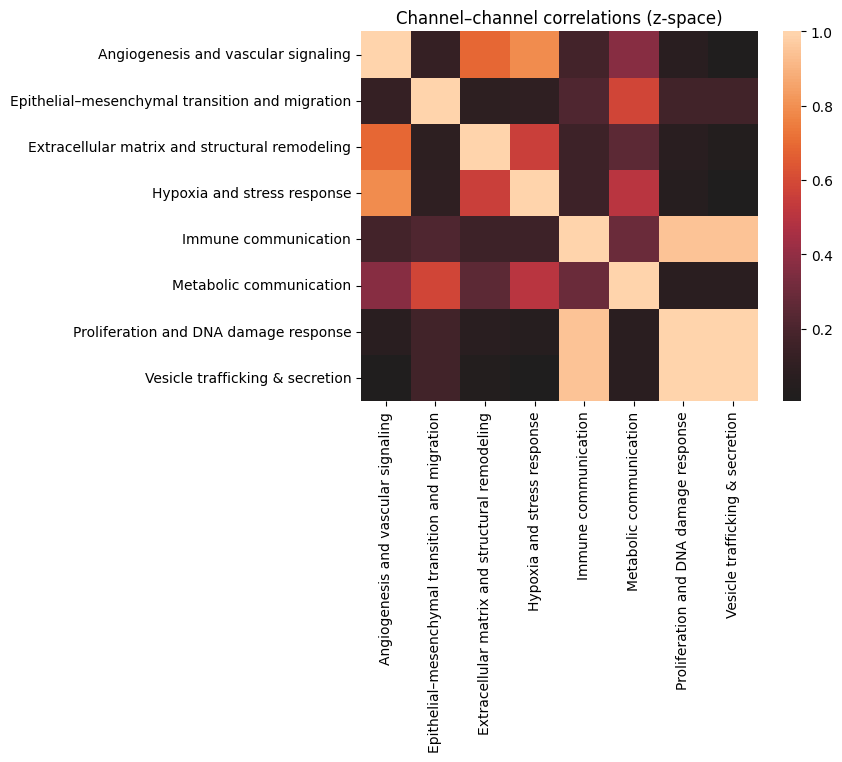

In [38]:
# visualize normalized per-cell channel matrix
import seaborn as sns, matplotlib.pyplot as plt
Xz = adata_interp.obsm["X_channels_dag_z"]
ch = adata_interp.uns["channels_order"]
sns.heatmap(np.corrcoef(Xz.T), xticklabels=ch, yticklabels=ch, center=0)
plt.title("Channel–channel correlations (z-space)")
plt.show()

In [39]:
# ===============================
# Phase 2 — Cell–pair crosstalk
# ===============================
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.neighbors import NearestNeighbors

# ------------------------------
# 0) Inputs & sanity checks
# ------------------------------
adata = adata_interp  # your interpretable AnnData

if "X_channels_dag" not in adata.obsm:
    raise ValueError("Missing adata.obsm['X_channels_dag'] — run Phase 1 DAG roll-up first.")

X_ch = np.asarray(adata.obsm["X_channels_dag"], dtype=np.float32)     # [N, C]
channels = list(adata.uns.get("channels_order", [f"ch_{i}" for i in range(X_ch.shape[1])]))
if X_ch.shape[1] != len(channels):
    raise ValueError("Channel axis mismatch between X_channels_dag and channels_order.")

# Optional: z-score channels across cells (recommended before similarities)
mu = X_ch.mean(axis=0, keepdims=True)
sd = X_ch.std(axis=0, keepdims=True); sd[sd < 1e-8] = 1.0
Xz = (X_ch - mu) / sd

# Neighborhood source (prefer true spatial)
if "spatial" in adata.obsm:
    X_nn = np.asarray(adata.obsm["spatial"], dtype=np.float32)  # [N, 2] or [N,3]
    space_name = "spatial"
else:
    # Fallback: use channel-z space for kNN if spatial not available
    X_nn = Xz
    space_name = "channel-z"

N, C = Xz.shape
print(f"[Phase2] N={N} cells, C={C} channels; neighbor space={space_name}")

# -------------------------------------
# 1) Neighborhood construction options
# -------------------------------------
K = 12                 # kNN degree (excluding self)
RADIUS = None          # set (e.g., 50.0) to use radius graph instead of kNN
METRIC = "euclidean"   # for neighbor search over X_nn

# Build neighbor index
nbrs = NearestNeighbors(
    n_neighbors=(K+1 if RADIUS is None else 1),
    radius=(RADIUS if RADIUS is not None else None),
    metric=METRIC,
    algorithm="auto"
).fit(X_nn)

if RADIUS is None:
    dists, idxs = nbrs.kneighbors(X_nn, n_neighbors=K+1, return_distance=True)
    # drop self (first neighbor)
    dists = dists[:, 1:]
    idxs  = idxs[:, 1:]
else:
    # radius graph — variable degree per node
    # kneighbors_radius returns ragged lists; we’ll compact
    idxs_list = []
    dists_list = []
    for i in range(N):
        di, ii = nbrs.radius_neighbors(X_nn[i:i+1], radius=RADIUS, return_distance=True)
        di, ii = di[0], ii[0]
        # drop self if present
        mask = ii != i
        idxs_list.append(ii[mask])
        dists_list.append(di[mask])
    # pad to jagged with dtype=object for iteration
    idxs = np.array(idxs_list, dtype=object)
    dists = np.array(dists_list, dtype=object)

# -------------------------------------
# 2) Spatial kernel (Gaussian)
#     sigma = median neighbor distance
# -------------------------------------
if RADIUS is None:
    sigma = float(np.median(dists))
else:
    # collect all distances into one vector for robust sigma
    all_d = np.concatenate([di for di in dists if len(di) > 0]) if len(dists) else np.array([1.0])
    sigma = float(np.median(all_d)) if all_d.size > 0 else 1.0
sigma = max(sigma, 1e-6)
print(f"[Phase2] spatial kernel sigma={sigma:.4g}")

def w_spatial_from_dist(d):
    # d can be scalar or array
    return np.exp(-(d**2) / (sigma**2))

# -------------------------------------
# 3) Per-pair per-channel similarity
#     sim_mode: 'min' (fuzzy-AND), 'product', or 'cosine'
# -------------------------------------
SIM_MODE = "min"   # 'min' | 'product' | 'cosine'

def pair_channel_similarity(v_i, v_j, mode="min"):
    """
    v_i, v_j: 1D arrays (length C), here we use Xz (z-scored channels).
    Returns per-channel vector sim[C] >= 0 (clip negatives to 0 for min/product).
    """
    if mode == "min":
        s = np.minimum(v_i, v_j)
        return np.clip(s, 0, None)  # keep shared positive signal
    elif mode == "product":
        s = v_i * v_j
        return np.clip(s, 0, None)
    elif mode == "cosine":
        # cosine similarity is a scalar — broadcast same score to all channels (not ideal for per-channel)
        num = float(np.dot(v_i, v_j))
        den = (np.linalg.norm(v_i) * np.linalg.norm(v_j) + 1e-8)
        cos = max(num / den, 0.0)
        return np.full_like(v_i, cos)
    else:
        raise ValueError(f"Unknown sim_mode: {mode}")

# -------------------------------------
# 4) Stream & build long sparse edge table
#     Columns: i, j, channel, score, w_spatial, score_weighted, distance
# -------------------------------------
rows = []
# iterate nodes; keep upper triangle only (i<j) to avoid duplicates
for i in range(N):
    js = idxs[i] if RADIUS is not None else idxs[i, :]
    ds = dists[i] if RADIUS is not None else dists[i, :]
    if js is None or len(js) == 0:
        continue
    # mask j > i to keep upper triangle
    if RADIUS is None:
        mask = js > i
        js_sel = js[mask]; ds_sel = ds[mask]
    else:
        js_sel = js[js > i]
        ds_sel = ds[js > i]
    if js_sel.size == 0:
        continue

    v_i = Xz[i, :]
    # vectorized: compute per-channel sim for each neighbor j, then append
    for j, d in zip(js_sel, ds_sel):
        v_j = Xz[j, :]
        s_vec = pair_channel_similarity(v_i, v_j, mode=SIM_MODE)            # (C,)
        w = w_spatial_from_dist(d)
        sw = s_vec * w
        # build long rows only if any positive signal
        if np.any(sw > 0):
            # pack as rows per channel (sparse-friendly)
            for c_idx in np.where(sw > 0)[0]:
                rows.append((
                    i, j, channels[c_idx],
                    float(s_vec[c_idx]),
                    float(w),
                    float(sw[c_idx]),
                    float(d)
                ))

edge_df = pd.DataFrame(rows, columns=[
    "i", "j", "channel", "score", "w_spatial", "score_weighted", "distance"
])

# -------------------------------------
# 5) QC summaries
# -------------------------------------
print("\n[Phase2] Edge table built:")
print(f"  edges (long rows)     : {len(edge_df):,}")
print(f"  unique undirected pairs: {edge_df[['i','j']].drop_duplicates().shape[0]:,}")
print(f"  channels               : {len(channels)} ({channels})")

print("\n[Top channels by median weighted score]")
print(edge_df.groupby("channel")["score_weighted"].median().sort_values(ascending=False).head(10))

print("\n[Example edges]")
display(edge_df.sample(min(10, len(edge_df)), random_state=0))

# -------------------------------------
# 6) (Optional) persist to disk for Phase 3
# -------------------------------------
# edge_df.to_parquet("/path/to/crosstalk_edges.parquet", index=False)

[Phase2] N=81236 cells, C=8 channels; neighbor space=spatial
[Phase2] spatial kernel sigma=91.98

[Phase2] Edge table built:
  edges (long rows)     : 277,154
  unique undirected pairs: 146,347
  channels               : 8 (['Angiogenesis and vascular signaling', 'Epithelial–mesenchymal transition and migration', 'Extracellular matrix and structural remodeling', 'Hypoxia and stress response', 'Immune communication', 'Metabolic communication', 'Proliferation and DNA damage response', 'Vesicle trafficking & secretion'])

[Top channels by median weighted score]
channel
Proliferation and DNA damage response              0.384820
Vesicle trafficking & secretion                    0.381090
Extracellular matrix and structural remodeling     0.047202
Angiogenesis and vascular signaling                0.027082
Immune communication                               0.013237
Hypoxia and stress response                        0.008076
Metabolic communication                            0.004245
Epithel

,i,j,channel,score,w_spatial,score_weighted,distance
69879,18150,18258,Hypoxia and stress response,0.037994,0.169529,0.006441,122.539783
114721,34081,34126,Hypoxia and stress response,0.008096,0.134904,0.001092,130.188325
134642,36926,37005,Angiogenesis and vascular signaling,0.195421,0.304962,0.059596,100.239713
221273,64156,64265,Extracellular matrix and structural remodeling,0.448276,0.056525,0.025339,155.913438
223205,64440,64553,Hypoxia and stress response,0.019255,0.112828,0.002172,135.871263
124312,35903,35970,Extracellular matrix and structural remodeling,0.316378,0.303668,0.096074,100.419122
118928,34924,34926,Hypoxia and stress response,0.003714,0.662632,0.002461,59.008474
29,11,131,Extracellular matrix and structural remodeling,0.076440,0.190145,0.014535,118.511603
41184,10106,10136,Hypoxia and stress response,0.042825,0.118864,0.005090,134.238594
41415,10156,10254,Angiogenesis and vascular signaling,0.202917,0.098048,0.019896,140.174891


In [40]:
edge_df

,i,j,channel,score,w_spatial,score_weighted,distance
0,5,62,Extracellular matrix and structural remodeling,0.089157,0.815949,0.072748,41.484937
1,5,18431,Angiogenesis and vascular signaling,0.058246,0.769127,0.044798,47.127494
2,5,18431,Extracellular matrix and structural remodeling,0.040918,0.769127,0.031471,47.127494
3,5,18989,Angiogenesis and vascular signaling,0.058246,0.380302,0.022151,90.443360
4,5,18989,Extracellular matrix and structural remodeling,0.090721,0.380302,0.034502,90.443360
...,...,...,...,...,...,...,...
277149,81197,81200,Extracellular matrix and structural remodeling,0.142127,0.192861,0.027411,118.004237
277150,81197,81200,Hypoxia and stress response,0.046241,0.192861,0.008918,118.004237
277151,81199,81217,Angiogenesis and vascular signaling,0.194564,0.303632,0.059076,100.424101
277152,81199,81217,Hypoxia and stress response,0.017085,0.303632,0.005187,100.424101


In [45]:
# ==============================
# Diagnostic (1): channel means per cell type
# ==============================
import numpy as np
import pandas as pd

A = adata_interp  # convenience

# --- pull channel matrix & names
if "X_channels_dag" not in A.obsm:
    raise ValueError("Missing A.obsm['X_channels_dag'] — run Phase 1 DAG roll-up first.")
X_ch = np.asarray(A.obsm["X_channels_dag"], dtype=np.float32)
channels = list(A.uns.get("channels_order", [f"ch_{i}" for i in range(X_ch.shape[1])]))
if X_ch.shape[1] != len(channels):
    raise ValueError("Channel axis mismatch between X_channels_dag and channels_order.")

# --- choose a cell-type column
CT_COLS_TRY = ["author_cell_type", "cell_type", "celltype", "cell_type_major"]
ct_col = next((c for c in CT_COLS_TRY if c in A.obs.columns), None)
if ct_col is None:
    raise ValueError(f"Could not find a cell-type column in A.obs; tried {CT_COLS_TRY}")

celltypes = A.obs[ct_col].astype(str).fillna("NA")

# --- compute means: (cell type) x (channel)
df_ct_means = (
    pd.DataFrame(X_ch, index=A.obs_names, columns=channels)
      .assign(__ct=celltypes.values)
      .groupby("__ct")[channels]
      .mean()
      .sort_index()
)

# also count cells per type (for context)
ct_counts = celltypes.value_counts().sort_index()
df_ct_means["__n_cells"] = ct_counts.reindex(df_ct_means.index).fillna(0).astype(int)

# --- z-score across cell types per channel (optional, for comparability)
df_ct_means_z = df_ct_means[channels].copy()
df_ct_means_z = (df_ct_means_z - df_ct_means_z.mean(axis=0)) / (df_ct_means_z.std(axis=0) + 1e-8)
df_ct_means_z["__n_cells"] = df_ct_means["__n_cells"]

# --- quick textual summaries
print("\n[Summary] Top 10 cell types by Immune communication mean")
ch = "Immune communication" if "Immune communication" in channels else channels[0]
print(df_ct_means[[ch, "__n_cells"]].sort_values(ch, ascending=False).head(10))

print("\n[Summary] For the top immune-like cell types, their top-5 channels:")
immune_like = df_ct_means[[ch]].sort_values(ch, ascending=False).head(5).index.tolist()
for ct in immune_like:
    top5 = df_ct_means.loc[ct, channels].sort_values(ascending=False).head(5)
    print(f"  - {ct} (n={df_ct_means.loc[ct,'__n_cells']}):")
    for k, v in top5.items():
        print(f"      {k:45s} {v: .4g}")

# --- Global channel means across ALL cells
global_means = X_ch.mean(axis=0)                     # (C,)
global_means_s = pd.Series(global_means, index=channels).sort_values(ascending=False)
print("\n[Global] Channel means across ALL cells (descending):")
print(global_means_s.round(6))

# (optional) attach to .uns for quick reuse
A.uns["phase2_diag_global_channel_means"] = global_means_s

# --- nice tables to inspect
display(df_ct_means.sort_values("__n_cells", ascending=False).head(20))         # raw means
display(df_ct_means_z.sort_values("__n_cells", ascending=False).head(20))       # z across CTs

# --- stash to .uns for later plotting/reporting
A.uns["phase2_diag_celltype_channel_means"] = df_ct_means
A.uns["phase2_diag_celltype_channel_means_z"] = df_ct_means_z
print("\n[Saved] A.uns['phase2_diag_celltype_channel_means'] and _means_z")


[Summary] Top 10 cell types by Immune communication mean
              Immune communication  __n_cells
__ct                                         
tumor 9                   0.001057        170
tumor 13                  0.000939      26030
plasmablast               0.000647       1638
mast                      0.000516       1487
mDC                       0.000506        338
T CD4 naive               0.000489         62
fibroblast                0.000387      13609
B-cell                    0.000368         70
NK                        0.000367        105
T CD8 memory              0.000326       3067

[Summary] For the top immune-like cell types, their top-5 channels:
  - tumor 9 (n=170):
      Vesicle trafficking & secretion                0.008893
      Proliferation and DNA damage response          0.005145
      Immune communication                           0.001057
      Epithelial–mesenchymal transition and migration  0.0001402
      Hypoxia and stress response                

,Angiogenesis and vascular signaling,Epithelial–mesenchymal transition and migration,Extracellular matrix and structural remodeling,Hypoxia and stress response,Immune communication,Metabolic communication,Proliferation and DNA damage response,Vesicle trafficking & secretion,__n_cells
__ct,,,,,,,,,
tumor 13,0.000200,0.000568,0.000236,0.000263,0.000939,0.000197,0.005158,0.009020,26030
macrophage,0.000136,0.000170,0.000069,0.000150,0.000189,0.000078,0.000679,0.001181,17989
fibroblast,0.000065,0.000155,0.000060,0.000133,0.000387,0.000160,0.001767,0.003212,13609
T CD4 memory,0.000111,0.000102,0.000060,0.000173,0.000240,0.000087,0.000901,0.001518,9344
T CD8 memory,0.000159,0.001039,0.000086,0.000191,0.000326,0.000271,0.001343,0.002338,3067
pDC,0.000082,0.000101,0.000058,0.000095,0.000151,0.000064,0.000481,0.000838,2702
Treg,0.000108,0.000257,0.000048,0.000143,0.000220,0.000099,0.000869,0.001495,2244
plasmablast,0.000057,0.000233,0.000054,0.000071,0.000647,0.000078,0.003809,0.006610,1638
mast,0.000057,0.000034,0.000049,0.000122,0.000516,0.000076,0.000082,0.000133,1487


,Angiogenesis and vascular signaling,Epithelial–mesenchymal transition and migration,Extracellular matrix and structural remodeling,Hypoxia and stress response,Immune communication,Metabolic communication,Proliferation and DNA damage response,Vesicle trafficking & secretion,__n_cells
__ct,,,,,,,,,
tumor 13,2.619498,0.225274,4.139357,1.875493,2.244662,1.388320,2.453338,2.469187,26030
macrophage,1.143627,-0.332679,0.102563,0.448638,-0.588127,-0.274561,-0.337159,-0.335707,17989
fibroblast,-0.483267,-0.353066,-0.109333,0.235133,0.160159,0.873676,0.340496,0.391020,13609
T CD4 memory,0.577041,-0.427395,-0.126501,0.742314,-0.395381,-0.138117,-0.199268,-0.214854,9344
T CD8 memory,1.687115,0.885606,0.504549,0.972460,-0.068597,2.418312,0.076292,0.078240,3067
pDC,-0.103883,-0.428390,-0.167018,-0.239604,-0.729052,-0.463967,-0.460767,-0.458338,2702
Treg,0.503124,-0.210474,-0.408519,0.359072,-0.469394,0.017582,-0.218872,-0.223046,2244
plasmablast,-0.666820,-0.244129,-0.255975,-0.550062,1.142190,-0.271888,1.613198,1.606676,1638
mast,-0.681940,-0.522105,-0.380313,0.091655,0.647451,-0.301831,-0.709033,-0.710417,1487



[Saved] A.uns['phase2_diag_celltype_channel_means'] and _means_z


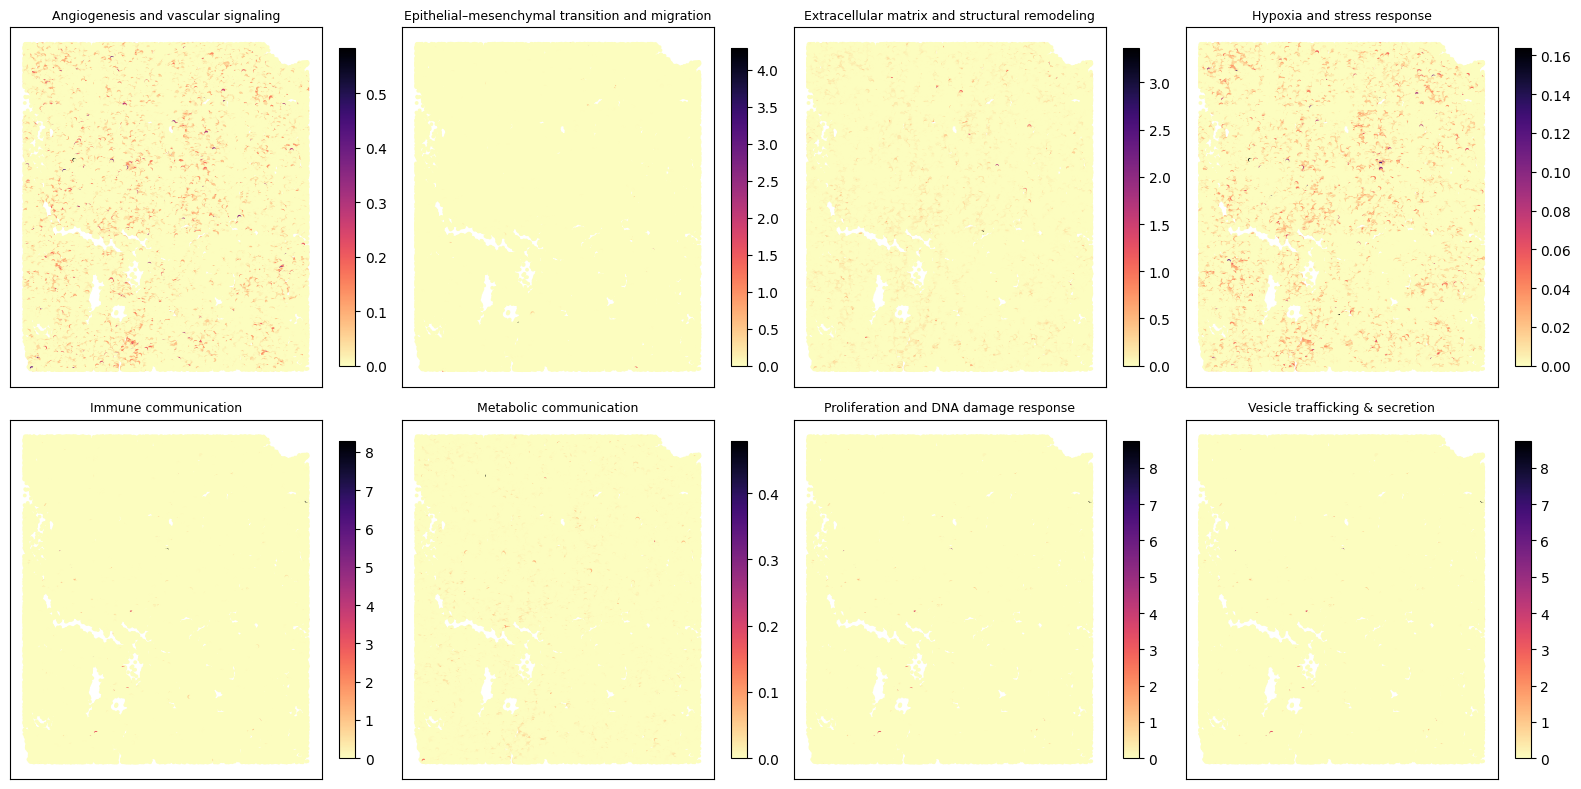

In [41]:
import matplotlib.pyplot as plt

spatial = adata_interp.obsm["spatial"]
channels = sorted(edge_df["channel"].unique())
ncols = 4
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(16, 8))

for ax, ch in zip(axes.flat, channels):
    # mean edge weight per cell for this channel
    vals = edge_df.loc[edge_df["channel"]==ch].groupby("i")["score_weighted"].mean()
    v = np.zeros(adata_interp.n_obs)
    v[vals.index] = vals.values
    sc = ax.scatter(spatial[:,0], spatial[:,1], c=v, s=3, cmap="magma_r")
    ax.set_title(ch, fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])
    plt.colorbar(sc, ax=ax, fraction=0.046)
plt.tight_layout()
plt.show()

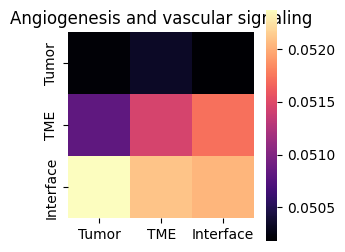

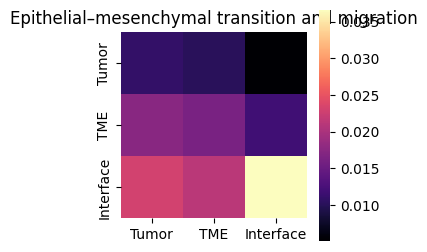

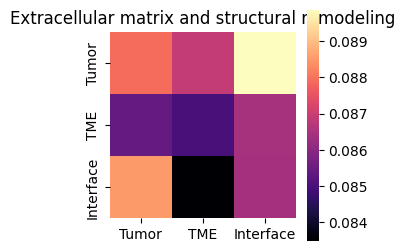

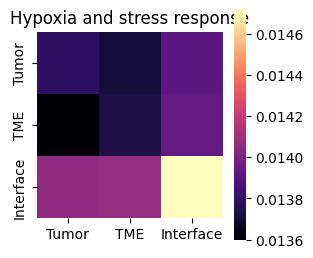

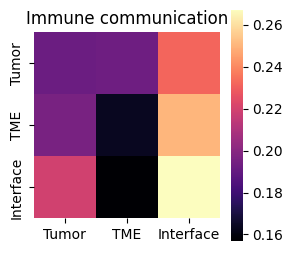

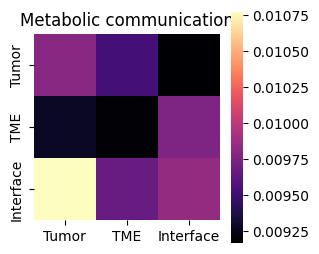

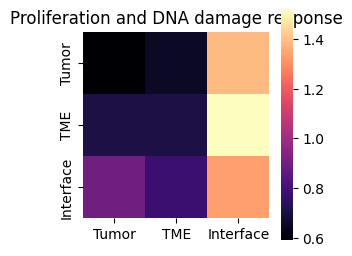

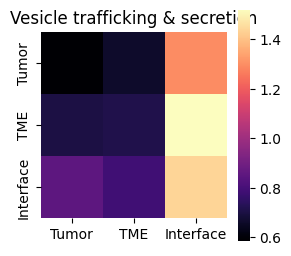

In [42]:
import seaborn as sns
comp = adata_interp.obs["compartment"].values  # e.g. Tumor/TME/Interface
mat = np.zeros((3,3,len(channels)))

comp_map = {"Tumor":0, "TME":1, "Interface":2}
for ch_idx, ch in enumerate(channels):
    dfc = edge_df[edge_df["channel"]==ch]
    comp_i = comp[dfc["i"]]
    comp_j = comp[dfc["j"]]
    for (ci, cj), g in dfc.groupby([comp_i, comp_j]):
        if ci in comp_map and cj in comp_map:
            mat[comp_map[ci], comp_map[cj], ch_idx] = g["score_weighted"].mean()

for ch_idx, ch in enumerate(channels):
    plt.figure(figsize=(3,3))
    sns.heatmap(mat[:,:,ch_idx], xticklabels=["Tumor","TME","Interface"],
                yticklabels=["Tumor","TME","Interface"], cmap="magma", square=True)
    plt.title(ch)
    plt.show()

In [43]:
# sanity check with the existing biological evidences

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Inputs and small conveniences
# -----------------------------
assert "compartment" in adata_interp.obs.columns, "compartment labels missing on adata_interp.obs"
COMP_ORDER = ["Tumor","TME","Interface"]
comp = pd.Categorical(adata_interp.obs["compartment"].astype(str), categories=COMP_ORDER)
comp_codes = comp.codes.values  # -1 for NA

score_col = "score_weighted" if "score_weighted" in edge_df.columns else "score"
if score_col not in edge_df.columns:
    raise ValueError("edge_df must have 'score_weighted' or 'score' column")

# Ensure numpy arrays for speed
i = edge_df["i"].to_numpy(np.int64)
j = edge_df["j"].to_numpy(np.int64)
s = edge_df[score_col].to_numpy(np.float32)
ch = edge_df["channel"].astype("category")
channels = list(ch.cat.categories)
ch_codes = ch.cat.codes.to_numpy(np.int16)

# Filter edges with known compartments on both endpoints
mask_ok = (i >= 0) & (j >= 0)
mask_ok &= (comp_codes[i] >= 0) & (comp_codes[j] >= 0)
i = i[mask_ok]; j = j[mask_ok]; s = s[mask_ok]; ch_codes = ch_codes[mask_ok]

ci = comp_codes[i]
cj = comp_codes[j]
# make unordered (symmetric) compartment pair key: (min,max)
cmin = np.minimum(ci, cj)
cmax = np.maximum(ci, cj)
pair_code = cmin * len(COMP_ORDER) + cmax  # 0..8 (upper triangle including diagonal)

# -----------------------------------
# 1) Mean edge intensity by (pair,channel)
# -----------------------------------
n_pairs = len(COMP_ORDER) * len(COMP_ORDER)  # 9; we will only display upper-triangle unique pairs
df_sum = pd.DataFrame(
    0.0, index=pd.MultiIndex.from_product([range(len(channels)), range(n_pairs)], names=["ch","pair"]),
    columns=["sum","cnt"]
)

# accumulate sums & counts
for k in range(len(s)):
    df_sum.loc[(ch_codes[k], pair_code[k]), "sum"] += s[k]
    df_sum.loc[(ch_codes[k], pair_code[k]), "cnt"] += 1

df_sum["mean"] = df_sum["sum"] / np.clip(df_sum["cnt"], 1, None)

# helper to decode pair code → names
def decode_pair(pc):
    a = pc // len(COMP_ORDER)
    b = pc % len(COMP_ORDER)
    return COMP_ORDER[a], COMP_ORDER[b]

rows = []
for (ck, pk), row in df_sum.iterrows():
    a, b = decode_pair(pk)
    # only keep upper triangle unique (a<=b by construction)
    rows.append({
        "channel": channels[ck],
        "pair_code": pk,
        "pair": f"{a}↔{b}",
        "A": a, "B": b,
        "mean": row["mean"],
        "count": int(row["cnt"])
    })
pair_means = pd.DataFrame(rows)
pair_means_wide = pair_means.pivot(index="channel", columns="pair", values="mean").fillna(0.0)
pair_means_wide = pair_means_wide.reindex(index=channels, columns=[
    "Tumor↔Tumor", "Tumor↔TME", "Tumor↔Interface", "TME↔TME", "TME↔Interface", "Interface↔Interface"
])

print("[Pair means per channel]")
display(pair_means_wide.style.format("{:.4f}"))

# -----------------------------------
# 2) Quick barplots per channel (pair means)
# -----------------------------------
ncols = 4
nrows = int(np.ceil(len(channels)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3.2*nrows))
axes = np.array(axes).reshape(-1)
pairs_order = ["Tumor↔Tumor","Tumor↔TME","Tumor↔Interface","TME↔TME","TME↔Interface","Interface↔Interface"]

for ax, ch_name in zip(axes, channels):
    vals = pair_means[pair_means["channel"]==ch_name].set_index("pair").reindex(pairs_order)["mean"]
    ax.bar(range(len(pairs_order)), vals.values)
    ax.set_xticks(range(len(pairs_order)))
    ax.set_xticklabels(pairs_order, rotation=60, ha="right", fontsize=8)
    ax.set_title(ch_name, fontsize=10)
plt.tight_layout()
plt.show()

# -----------------------------------
# 3) Light permutation tests for expected contrasts
#     (shuffle compartment labels across cells; preserve edge structure)
# -----------------------------------
rng = np.random.default_rng(7)
N_PERM = 200  # increase if you want tighter p-values

# Define contrasts: (channel, pairA, pairB) → test A_mean - B_mean > 0
CONTRASTS = [
    ("Immune communication",                 "Tumor↔Interface",    "Tumor↔Tumor"),
    ("Hypoxia and stress response",          "Tumor↔Tumor",        "TME↔TME"),
    ("Extracellular matrix and structural remodeling", "TME↔Interface", "Tumor↔Tumor"),
    ("Epithelial–mesenchymal transition and migration", "TME↔Interface", "Tumor↔Tumor"),
    ("Proliferation and DNA damage response","Tumor↔Tumor",        "TME↔TME"),
    ("Angiogenesis and vascular signaling",  "TME↔Interface",      "Tumor↔TME"),
]

# Map pair name to code for fast selection
pair_name_to_code = {f"{a}↔{b}": (COMP_ORDER.index(a)*len(COMP_ORDER)+COMP_ORDER.index(b)) if COMP_ORDER.index(a)<=COMP_ORDER.index(b)
                     else (COMP_ORDER.index(b)*len(COMP_ORDER)+COMP_ORDER.index(a))
                     for a in COMP_ORDER for b in COMP_ORDER}

# observed deltas
obs = []
for (ch_name, pairA, pairB) in CONTRASTS:
    m = pair_means_wide.loc[ch_name]
    delta = m[pairA] - m[pairB]
    obs.append((ch_name, pairA, pairB, float(delta)))
obs_df = pd.DataFrame(obs, columns=["channel","pairA","pairB","delta_obs"])

# permutation deltas
perm_deltas = np.zeros((len(CONTRASTS), N_PERM), dtype=np.float32)

# precompute channel masks
ch_to_mask = {k: (ch_codes == idx) for idx, k in enumerate(channels)}

for p in range(N_PERM):
    # shuffle compartments across cells
    perm_codes = comp_codes.copy()
    rng.shuffle(perm_codes)
    ci_perm = perm_codes[i]
    cj_perm = perm_codes[j]
    cmin_p = np.minimum(ci_perm, cj_perm)
    cmax_p = np.maximum(ci_perm, cj_perm)
    pair_code_perm = cmin_p * len(COMP_ORDER) + cmax_p

    for t_idx, (ch_name, pairA, pairB) in enumerate(CONTRASTS):
        mask_ch = ch_to_mask.get(ch_name, None)
        if mask_ch is None: 
            continue
        pcA = pair_name_to_code[pairA]
        pcB = pair_name_to_code[pairB]
        selA = mask_ch & (pair_code_perm == pcA)
        selB = mask_ch & (pair_code_perm == pcB)
        meanA = s[selA].mean() if selA.any() else 0.0
        meanB = s[selB].mean() if selB.any() else 0.0
        perm_deltas[t_idx, p] = meanA - meanB

# summarize permutation p-values (one-sided: obs > perm)
summary = []
for t_idx, row in obs_df.iterrows():
    d_obs = row["delta_obs"]
    null = perm_deltas[t_idx]
    p_emp = (np.sum(null >= d_obs) + 1) / (len(null) + 1)
    z = (d_obs - null.mean()) / (null.std() + 1e-9)
    summary.append({
        "channel": row["channel"],
        "contrast": f"{row['pairA']}  >  {row['pairB']}",
        "delta_obs": d_obs,
        "delta_null_mean": float(null.mean()),
        "delta_null_sd": float(null.std()),
        "z_score": float(z),
        "p_perm_one_sided": float(p_emp),
    })
summary_df = pd.DataFrame(summary).sort_values(["p_perm_one_sided","channel"])
print("\n[Permutation contrasts — sanity checks]")
display(summary_df.style.format({
    "delta_obs": "{:.4g}", "delta_null_mean": "{:.4g}", "delta_null_sd": "{:.4g}",
    "z_score": "{:.2f}", "p_perm_one_sided": "{:.3g}"
}))

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [51]:
# ============================================================
# Phase 2 (DAG-aware) — Cell–pair crosstalk on 393 GO features
# ============================================================
import numpy as np
import pandas as pd
import scipy.sparse as sp
from collections import defaultdict, deque
from sklearn.neighbors import NearestNeighbors

# -----------------------------
# 0) Inputs (from Phase 1)
# -----------------------------
adata = adata_interp  # interpretable AnnData (cells x ~393 concepts)

# X_terms can be sparse; convert ONLY when needed downstream
X_terms_raw = adata.X                      # [N, T]
if sp.issparse(X_terms_raw):
    N, T = X_terms_raw.shape
else:
    X_terms_raw = np.asarray(X_terms_raw, dtype=np.float32)
    N, T = X_terms_raw.shape

terms = adata.var_names.astype(str).tolist()

# Required annotations from Phase 1
req_cols = {"channel_primary", "is_generic"}
if not req_cols.issubset(adata.var.columns):
    raise ValueError(f"Missing adata.var columns {req_cols}. Run Phase 1 mapping first.")

# Prefer mapped GO IDs; else assume var_names are GO IDs (you already mapped earlier)
if "go_id" in adata.var.columns and adata.var["go_id"].notna().any():
    go_ids = adata.var["go_id"].fillna(adata.var_names).astype(str).tolist()
else:
    go_ids = terms

# -----------------------------
# 1) GO DAG: parent map
# -----------------------------
def build_parent_map_from_go_obo(obo_path):
    """Build GO parent map using GOATOOLS (is_a parents)."""
    from goatools.obo_parser import GODag
    go = GODag(obo_path)
    pm = {}
    for go_id, rec in go.items():
        pm[go_id] = [p.id for p in rec.parents]
    return pm

GO_OBO = "/maiziezhou_lab2/yunfei/Projects/interpTFM/evaluation/f1_related/go-basic.obo"
parent_map = build_parent_map_from_go_obo(GO_OBO)

# Keep only go_ids present in the DAG (report coverage)
in_dag_mask = np.array([g in parent_map for g in go_ids], dtype=bool)
n_in = int(in_dag_mask.sum())
print(f"[GO DAG] recognized: {n_in} / {T} terms")

# -----------------------------
# 2) DAG neighborhood (for distances)
# -----------------------------
def collect_with_ancestors(term_list, parent_map, max_hops=6):
    """Return set of nodes consisting of term_list and their ancestors up to max_hops."""
    nodes = set(term_list)
    for t in term_list:
        q = deque([(t, 0)])
        seen = {t}
        while q:
            cur, d = q.popleft()
            if d == max_hops: 
                continue
            for p in parent_map.get(cur, []):
                if p not in seen:
                    seen.add(p); q.append((p, d+1))
                    nodes.add(p)
    return nodes

def shortest_path_distances(nodes, parent_map):
    """
    Compute undirected shortest-path distances among 'nodes', using child<->parent edges.
    Returns (nodes_list, index_map, D) with D[i,j] = hop distance or inf if disconnected.
    """
    adj = defaultdict(set)
    for child in nodes:
        for p in parent_map.get(child, []):
            if p in nodes:
                adj[child].add(p)
                adj[p].add(child)

    nodes_list = list(nodes)
    idx = {n:i for i,n in enumerate(nodes_list)}
    D = np.full((len(nodes_list), len(nodes_list)), np.inf, dtype=np.float32)
    for i, src in enumerate(nodes_list):
        D[i, i] = 0.0
        q = deque([src])
        visited = {src}
        while q:
            u = q.popleft()
            for v in adj[u]:
                if v not in visited:
                    visited.add(v)
                    D[i, idx[v]] = D[i, idx[u]] + 1.0
                    q.append(v)
    return nodes_list, idx, D

# If coverage is poor, we will fall back to identity kernel later
HOPS_FOR_GRAPH = 6
tau = 3.0

if n_in > 0:
    dag_nodes = collect_with_ancestors([g for g in go_ids if g in parent_map], parent_map, max_hops=HOPS_FOR_GRAPH)
    nodes_all, idx_all, D_all = shortest_path_distances(dag_nodes, parent_map)
else:
    nodes_all, idx_all, D_all = [], {}, None

# -----------------------------
# 3) Semantic kernel G on your T terms
# -----------------------------
# Map your term order -> indices in D_all; terms not found get 0 sim except identity=1
if n_in > 0:
    idx_in_all = np.array([idx_all.get(g, -1) for g in go_ids], dtype=int)
    D_terms = np.full((T, T), np.inf, dtype=np.float32)
    hits = idx_in_all >= 0
    for a in range(T):
        ia = idx_in_all[a]
        if ia < 0: 
            continue
        row = D_all[ia]
        D_terms[a, hits] = row[idx_in_all[hits]]
    G = np.exp(-D_terms / float(tau)).astype(np.float32)
    np.fill_diagonal(G, 1.0)
    G[np.isinf(D_terms)] = 0.0
    if np.any(G > 0):
        print(f"[Kernel] τ={tau} | G>0 min={G[G>0].min():.3g}, median={np.median(G[G>0]):.3g}, max={G.max():.3g}")
    else:
        print("[Kernel] Warning: no finite paths; using identity fallback.")
        G = np.eye(T, dtype=np.float32)
else:
    print("[Kernel] GO coverage is zero — using identity kernel.")
    G = np.eye(T, dtype=np.float32)

# Optional IC weights (feature specificity)
def compute_term_ic(X):
    if sp.issparse(X):
        nz = np.array(X.getnnz(axis=0)).ravel()
        n  = X.shape[0]
    else:
        nz = np.count_nonzero(X, axis=0)
        n  = X.shape[0]
    p = np.clip(nz / max(n, 1), 1e-6, 1.0)
    return (-np.log(p)).astype(np.float32)

USE_IC = True
IC = compute_term_ic(X_terms_raw) if USE_IC else np.ones(T, dtype=np.float32)
W = IC  # elementwise

# -----------------------------
# 4) Per-channel term indices (mechanistic only)
# -----------------------------
df_var = adata.var[["channel_primary","is_generic"]].copy()
mech_mask = (~df_var["is_generic"].fillna(False)) & df_var["channel_primary"].notna() & (df_var["channel_primary"] != "Unclassified")
channels = sorted(df_var.loc[mech_mask, "channel_primary"].unique().tolist())

# robust index selection per channel
terms_idx_by_ch = {}
for c in channels:
    mask_c = mech_mask & (adata.var["channel_primary"] == c)
    idx_c = np.where(mask_c.values)[0]
    terms_idx_by_ch[c] = idx_c

print(f"[Channels] {len(channels)} mechanistic channels: {channels}")

# -----------------------------
# 5) Spatial radius graph (~20 nbrs)
# -----------------------------
if "spatial" in adata.obsm:
    X_nn = np.asarray(adata.obsm["spatial"], dtype=np.float32)
    space_name = "spatial"
else:
    # fallback small PCA of term space (dense)
    from sklearn.decomposition import PCA
    space_name = "terms-PCA"
    X_dense_for_pca = X_terms_raw.toarray() if sp.issparse(X_terms_raw) else X_terms_raw
    X_nn = PCA(n_components=min(10, T), random_state=0).fit_transform(X_dense_for_pca)

# auto-pick a radius so the 20th neighbor distance median is our R
target_k = 20
sub = np.random.default_rng(0).choice(N, size=min(2000, N), replace=False)
nbrs_sub = NearestNeighbors(n_neighbors=target_k+1, metric="euclidean").fit(X_nn[sub])
dists_sub, _ = nbrs_sub.kneighbors(X_nn[sub], n_neighbors=target_k+1, return_distance=True)
RADIUS = float(np.median(dists_sub[:, target_k])) if dists_sub.shape[1] > target_k else float(np.median(dists_sub[:, -1]))
print(f"[Neighbors] Auto radius (target_k={target_k}): RADIUS={RADIUS:.3g} in {space_name} space")

nbrs_full = NearestNeighbors(radius=RADIUS, metric="euclidean").fit(X_nn)
neighbors = []
all_d = []
for i in range(N):
    di, ii = nbrs_full.radius_neighbors(X_nn[i:i+1], radius=RADIUS, return_distance=True)
    di, ii = di[0], ii[0]
    mask = (ii != i)
    ii, di = ii[mask], di[mask]
    neighbors.append((ii, di))
    if di.size > 0:
        all_d.append(di)
all_d = np.concatenate(all_d) if len(all_d) else np.array([1.0], dtype=np.float32)
sigma = float(np.median(all_d)) if all_d.size > 0 else 1.0
sigma = max(sigma, 1e-6)
print(f"[Neighbors] median edge length σ={sigma:.3g}")

def w_spatial(d):
    return np.exp(-(d**2)/(sigma**2))

# -----------------------------
# 6) DAG-aware per-edge scoring
# s_c(i,j) = (f_i[Jc] ⊙ W[Jc])^T · G[Jc,Jc] · (f_j[Jc] ⊙ W[Jc])
# -----------------------------
# cache per-channel blocks
G_blocks = {c: G[np.ix_(idxs, idxs)] for c, idxs in terms_idx_by_ch.items()}
W_blocks = {c: W[terms_idx_by_ch[c]] for c in channels}

# z-score each term across cells before scoring (dense)
if sp.issparse(X_terms_raw):
    X_dense = X_terms_raw.toarray().astype(np.float32)
else:
    X_dense = X_terms_raw.astype(np.float32)

mu = X_dense.mean(axis=0, keepdims=True)
sd = X_dense.std(axis=0, keepdims=True)
sd[sd < 1e-8] = 1.0
Xz = (X_dense - mu) / sd  # [N, T]

rows = []
for i in range(N):
    js, ds = neighbors[i]
    if js is None or len(js) == 0:
        continue
    # keep only upper triangle
    mask = js > i
    js, ds = js[mask], ds[mask]
    if js.size == 0:
        continue

    fi = Xz[i, :]
    for j, d in zip(js, ds):
        fj = Xz[j, :]
        w = w_spatial(float(d))
        # per-channel scores
        for c in channels:
            J = terms_idx_by_ch[c]
            if J.size == 0:
                continue
            Gi = G_blocks[c]          # |J| x |J|
            wi = W_blocks[c]          # |J|
            vi = (fi[J] * wi)         # |J|
            vj = (fj[J] * wi)         # |J|
            s = float(vi @ (Gi @ vj)) # scalar
            if s <= 0:
                continue
            rows.append((i, j, c, s, w, s*w, float(d)))

edge_df = pd.DataFrame(rows, columns=["i","j","channel","score_raw","w_spatial","score_weighted","distance"])
print(f"\n[Edges] long rows = {len(edge_df):,} ; unique pairs = {edge_df[['i','j']].drop_duplicates().shape[0]:,}")

# -----------------------------
# 7) Per-channel normalization & QC
# -----------------------------
def zscore_per_channel(df, col="score_weighted"):
    out = []
    for c, sub in df.groupby("channel", sort=False):
        x = sub[col].to_numpy()
        mu, sd = x.mean(), x.std()
        z = np.zeros_like(x) if sd < 1e-12 else (x - mu) / sd
        tmp = sub.copy()
        tmp["z"] = z
        out.append(tmp)
    return pd.concat(out, axis=0, ignore_index=True)

edge_df = zscore_per_channel(edge_df, col="score_weighted")

print("\n[Channel medians of z] (should be ~0):")
print(edge_df.groupby("channel")["z"].median().sort_values())

print("\n[Top channels by raw median weighted score]")
print(edge_df.groupby("channel")["score_weighted"].median().sort_values(ascending=False).head(10))

print("\n[Examples] top edges by z within each channel")
examples = edge_df.sort_values(["channel","z"], ascending=[True,False]).groupby("channel").head(3)
display(examples)

# Optionally keep only strong edges
Z_MIN = 1.5
edge_strong = edge_df[edge_df["z"] >= Z_MIN].copy()
print(f"\n[Strong edges] z>={Z_MIN}: {len(edge_strong):,} rows")

# Optionally persist
# edge_df.to_parquet("/path/to/crosstalk_edges_dag.parquet", index=False)
# edge_strong.to_parquet("/path/to/crosstalk_edges_dag_strong.parquet", index=False)

TypeError: "value" parameter must be a scalar, dict or Series, but you passed a "Index"